In [ ]:
# 参考链接：https://github.com/lansinuote/More_Simple_Reinforcement_Learning

In [1]:
# 安装必要库
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple torch
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple stable-baselines3[extra]

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
     ---------------------------------------- 0.3/159.8 MB 6.5 MB/s eta 0:00:25
     ---------------------------------------- 0.6/159.8 MB 6.6 MB/s eta 0:00:24
     --------------------------------------- 1.5/159.8 MB 10.7 MB/s eta 0:00:15
     --------------------------------------- 1.9/159.8 MB 11.1 MB/s eta 0:00:15
      --------------------------------------- 2.1/159.8 MB 9.6 MB/s eta 0:00:17
      --------------------------------------- 2.4/159.8 MB 8.5 MB/s eta 0:00:19
      --------------------------------------- 2.5/159.8 MB 7.9 MB/s eta 0:00:21
      --------------------------------------- 2.5/159.8 MB 7.9 MB/s eta 0:00:21
      --------------------------------------- 2.5/159.8 MB 7.9 MB/s eta 0:00:21
      --------------------------------------- 2.5/159.8 MB 7.9 MB/s eta 0:00:21
      --------------------------------------- 2.5/159.8 MB 7.9 MB/

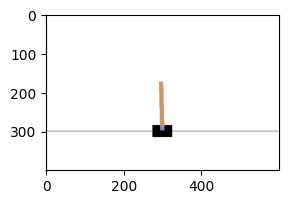

In [2]:
import gymnasium as gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [3]:
import torch

#定义模型,评估状态下每个动作的价值
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#延迟更新的模型,用于计算target
model_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#复制参数
model_delay.load_state_dict(model.state_dict())

model, model_delay

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

-983.0

In [6]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

(218,
 (array([-0.0309389 ,  0.037351  ,  0.03017377, -0.01802648], dtype=float32),
  1,
  1.0,
  array([-0.03019187,  0.23202752,  0.02981324, -0.3010386 ], dtype=float32),
  False))

In [7]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #复制参数
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)


train()

0 443 -990.8
100 20000 -786.8
200 20000 200.0
300 20000 200.0
400 20000 200.0
500 20000 -903.05
600 20000 -761.3
700 20000 200.0
800 20000 200.0
900 20000 42.4


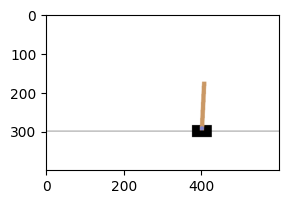

200.0

In [8]:
play(True)[-1]

In [9]:
# 导入stable-baseline3库
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import DQN

In [10]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [11]:
# 模型初始化
model = DQN("MlpPolicy", env, verbose=0)

In [12]:
# 未训练模型性能测试

mean_reward, std_reward = evaluate_policy(model,
                                          env,
                                          n_eval_episodes=5,
                                          deterministic=False)
print(mean_reward)
print(std_reward)

9.6
0.48989794855663565


e:\lihan\Program\Conda\envs\rl_tutorial\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [13]:
model.learn(total_timesteps=1e5)

In [14]:
mean_reward, std_reward = evaluate_policy(model,
                                          env,
                                          n_eval_episodes=5,
                                          deterministic=True)
print(mean_reward)
print(std_reward)

242.6
12.611106216347558
